In [64]:
# Wrangling data
from scipy.io import arff
import numpy as np
import pandas as pd
import warnings
import re
import time
import ipywidgets as widgets
from ipywidgets import interact

# Visualizing the data 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Some aggregation to statisticize data 
from scipy.stats.mstats import trimmed_var
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Build model
from imblearn.pipeline import make_pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Evaluate model
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Save model 
import pickle

In [70]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.3f}'.format

# Import Data

In [3]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    data = arff.loadarff(filename)[0]
        
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame(data=data)
    
    # Rename columns
    df.columns = [re.sub(pattern='Attr',repl='feat_',string=col) for col in df.columns]
    df.rename(columns={'class':'bankrupt'},inplace=True)
    
    # Change dtype of the Labels columns
    df['bankrupt'] = df['bankrupt'].astype(np.int64)
    return df

In [4]:
file_path = 'dataset/3year.arff'
df = wrangle(file_path)
bankrupt_df = df.copy()
print("Shape of DataFrame:",bankrupt_df.shape)
bankrupt_df.head()

Shape of DataFrame: (10503, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.174,0.413,0.144,1.348,-28.982,0.604,0.219,1.123,1.196,0.464,...,0.164,0.376,0.836,0.000,9.714,6.281,84.291,4.330,4.034,0
1,0.146,0.460,0.282,1.629,2.595,0.000,0.172,1.172,1.602,0.540,...,0.028,0.271,0.901,0.000,5.988,4.110,102.190,3.572,5.950,0
2,0.001,0.226,0.488,3.160,84.874,0.191,0.005,2.988,1.008,0.676,...,0.008,0.001,0.992,0.000,6.774,3.792,64.846,5.629,4.458,0
3,0.025,0.432,0.275,1.783,-10.105,0.569,0.025,1.306,1.051,0.565,...,0.048,0.043,0.952,0.143,4.229,5.053,98.783,3.695,3.484,0
4,0.188,0.415,0.342,1.928,-58.274,0.000,0.234,1.409,1.339,0.585,...,0.176,0.322,0.826,0.073,2.591,7.076,100.540,3.630,4.638,0


# Explore data

## Overview data

In [5]:
bankrupt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10503 entries, 0 to 10502
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    10503 non-null  float64
 1   feat_2    10503 non-null  float64
 2   feat_3    10503 non-null  float64
 3   feat_4    10485 non-null  float64
 4   feat_5    10478 non-null  float64
 5   feat_6    10503 non-null  float64
 6   feat_7    10503 non-null  float64
 7   feat_8    10489 non-null  float64
 8   feat_9    10500 non-null  float64
 9   feat_10   10503 non-null  float64
 10  feat_11   10503 non-null  float64
 11  feat_12   10485 non-null  float64
 12  feat_13   10460 non-null  float64
 13  feat_14   10503 non-null  float64
 14  feat_15   10495 non-null  float64
 15  feat_16   10489 non-null  float64
 16  feat_17   10489 non-null  float64
 17  feat_18   10503 non-null  float64
 18  feat_19   10460 non-null  float64
 19  feat_20   10460 non-null  float64
 20  feat_21   9696 non-null   fl

In [6]:
(bankrupt_df.isna().sum()/bankrupt_df.shape[0]).sort_values(ascending=False).head(10)

feat_37   0.451
feat_21   0.077
feat_27   0.068
feat_60   0.056
feat_45   0.056
feat_28   0.022
feat_53   0.022
feat_54   0.022
feat_64   0.022
feat_24   0.022
dtype: float64

In [7]:
# drop the feat 37 because the missing propotion is more than 40%
bankrupt_df.drop(columns='feat_37',inplace=True)

# Preprocess

## Split data 

In [8]:
target = "bankrupt"
X = bankrupt_df.drop(columns=target)
y = bankrupt_df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10503, 63)
y shape: (10503,)


In order to make sure that our model can generalize, we need to put aside a test set that we'll use to evaluate our model once it's trained. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8402, 63)
y_train shape: (8402,)
X_test shape: (2101, 63)
y_test shape: (2101,)


## Resample 

In [10]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (16028, 63)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.014,0.484,0.336,3.284,28.116,0.000,0.017,1.065,1.363,0.516,...,5550.800,0.015,0.027,0.987,0.000,5.881,5.766,39.379,9.269,2.635
1,0.056,0.287,0.340,2.212,41.783,0.152,0.066,2.179,0.930,0.626,...,5034.800,-0.076,0.089,1.076,0.011,11.784,5.463,62.549,5.835,4.328
2,0.125,0.212,-0.044,0.767,-26.932,0.427,0.155,3.714,1.176,0.788,...,-5127.200,0.150,0.159,0.850,0.032,68.975,10.712,63.477,5.750,1.255
3,0.271,0.348,0.419,2.243,300.000,0.129,0.303,1.877,8.682,0.652,...,1322.000,0.039,0.416,0.981,0.000,147.960,149.580,14.188,25.727,35.688
4,0.485,0.381,0.619,2.622,372.120,0.000,0.596,1.622,2.967,0.619,...,490.720,0.201,0.785,0.816,0.000,NaN,4.288,46.919,7.779,NaN


# Build model 

## Baseline 

In [11]:
acc_baseline = df['bankrupt'].value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9529


Create the baseline to compare with the accuracy score

## Iterate 

### Create Pipeline: RandomForest vs Gradient Booster

In [12]:
sampling=RandomOverSampler(random_state=42)

In [13]:
# Create 2 pipeline: random forest and gradient booster
# random forest
clf_rf = make_pipeline(
    SimpleImputer(),
    RandomOverSampler(random_state=42),
    RandomForestClassifier(random_state=42)
)
clf_rf

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomoversampler', RandomOverSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [14]:
# Gradient booster
clf_gb = make_pipeline(
    SimpleImputer(),
    RandomOverSampler(random_state=42),
    GradientBoostingClassifier(random_state=42)
)
clf_gb

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomoversampler', RandomOverSampler(random_state=42)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

In order to get the best performance from our model, we will implement to create params anf tune its hyperparameter.

### Create the params

In [15]:
# Random Forest Params
params_rf = {
    'simpleimputer__strategy': ['mean','median'],
    'randomforestclassifier__n_estimators': range(25,100,25),
    'randomforestclassifier__max_depth': range(10,50,10)
}
params_rf

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [16]:
# Gradient Booster Params
params_gb = {
    'simpleimputer__strategy': ['mean','median'],
    'gradientboostingclassifier__n_estimators': range(20,31,5),
    'gradientboostingclassifier__max_depth': range(2,5)
}
params_gb

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

### Use Cross validation to find the best model

In [17]:
model_rf = GridSearchCV(estimator=clf_rf,param_grid=params_rf,cv=5,n_jobs=-1,verbose=1)
model_rf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [18]:
model_gb = GridSearchCV(estimator=clf_gb,param_grid=params_gb,cv=5,n_jobs=-1,verbose=1)
model_gb

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

### Train model 

In [19]:
# Train model
start = time.time()
print(model_rf.fit(X_train,y_train))
diff = time.time() - start
print(f'Total diff time: {diff} second')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)
Total diff time: 126.13560771942139 second


In [20]:
# Fit model to over-sampled training data
start_time = time.time()
print(model_gb.fit(X_train,y_train))
diff = time.time() - start_time
print(f"Total time: {diff} sec")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)
Total time: 222.08275508880615 sec


### CV results Assessment

- Random Forest

In [21]:
results_rf = pd.DataFrame(model_rf.cv_results_)
results_rf.iloc[:,::-1].sort_values("rank_test_score").head(5)

,rank_test_score,std_test_score,mean_test_score,split4_test_score,split3_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_simpleimputer__strategy,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
16,1,0.001,0.960,0.962,0.958,0.958,0.960,0.960,"{'randomforestclassifier__max_depth': 30, 'ran...",mean,75,30,0.015,0.108,0.141,11.691
22,2,0.001,0.959,0.960,0.958,0.958,0.960,0.958,"{'randomforestclassifier__max_depth': 40, 'ran...",mean,75,40,0.018,0.098,0.641,11.109
12,3,0.001,0.959,0.960,0.957,0.958,0.961,0.957,"{'randomforestclassifier__max_depth': 30, 'ran...",mean,25,30,0.004,0.043,0.134,4.109
14,4,0.001,0.958,0.960,0.957,0.957,0.960,0.957,"{'randomforestclassifier__max_depth': 30, 'ran...",mean,50,30,0.014,0.067,0.083,7.847
18,5,0.001,0.958,0.958,0.957,0.958,0.960,0.957,"{'randomforestclassifier__max_depth': 40, 'ran...",mean,25,40,0.009,0.033,0.175,3.621


In [22]:
print(f"""Random Forest result:
The best param: {model_rf.best_params_}
The best score: {model_rf.score(X_test,y_test)}
""")

Random Forest result:
The best param: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 75, 'simpleimputer__strategy': 'mean'}
The best score: 0.9604950023798191



- Gradient Booster

In [23]:
results_gb = pd.DataFrame(model_gb.cv_results_)
results_gb.iloc[:,::-1].sort_values("rank_test_score").head(5)

,rank_test_score,std_test_score,mean_test_score,split4_test_score,split3_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_simpleimputer__strategy,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
16,1,0.005,0.891,0.883,0.895,0.887,0.891,0.898,"{'gradientboostingclassifier__max_depth': 4, '...",mean,30,4,0.003,0.015,0.472,26.119
14,2,0.005,0.879,0.872,0.886,0.874,0.881,0.882,"{'gradientboostingclassifier__max_depth': 4, '...",mean,25,4,0.005,0.016,0.458,21.789
17,3,0.012,0.873,0.868,0.875,0.854,0.876,0.890,"{'gradientboostingclassifier__max_depth': 4, '...",median,30,4,0.003,0.018,2.248,24.397
12,4,0.003,0.864,0.863,0.869,0.859,0.864,0.863,"{'gradientboostingclassifier__max_depth': 4, '...",mean,20,4,0.003,0.015,0.497,17.594
15,5,0.013,0.858,0.852,0.857,0.839,0.863,0.880,"{'gradientboostingclassifier__max_depth': 4, '...",median,25,4,0.003,0.017,0.173,22.224


In [24]:
print(f"""Gradient Booster result:
The best param: {model_gb.best_params_}
The best score: {model_gb.score(X_test,y_test)}
""")

Gradient Booster result:
The best param: {'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 30, 'simpleimputer__strategy': 'mean'}
The best score: 0.8895763921941933



As we see, Although Gradient Booster take more time than Random Forest, it is scored less than Random Forest. 

For this reason, we recommend to use Randomforest for this model.

Beside that, we should not choose the model with the best score. Instead, we could select the most proper model (running time, the score)

In [25]:
mask_1 = (results_rf.param_simpleimputer__strategy == 'mean')
visual_ = results_rf[mask_1].groupby(['param_randomforestclassifier__max_depth',
                 'param_randomforestclassifier__n_estimators',
                 'param_simpleimputer__strategy'],as_index=False).agg({'mean_test_score':'mean',
                                                        'mean_fit_time':'mean'}).sort_values('mean_fit_time').reset_index(drop=True)
visual_

,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,mean_test_score,mean_fit_time
0,10,25,mean,0.926,1.114
1,10,50,mean,0.930,2.274
2,40,25,mean,0.958,3.621
3,20,25,mean,0.958,3.708
4,30,25,mean,0.959,4.109
5,40,50,mean,0.958,7.307
6,20,50,mean,0.958,7.847
7,30,50,mean,0.958,7.847
8,10,75,mean,0.931,9.750
9,40,75,mean,0.959,11.109


In [26]:
visual_['max depth-estimators'] =  [f'{pair[0]}-{pair[1]}' for pair in visual_[['param_randomforestclassifier__max_depth','param_randomforestclassifier__n_estimators']].values]

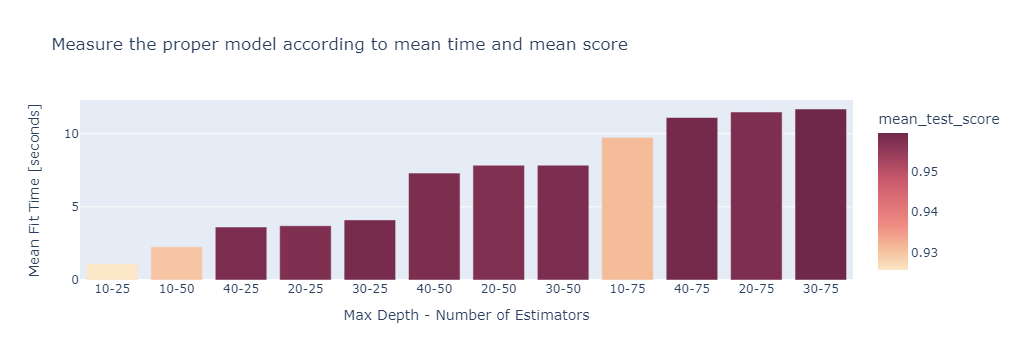

In [45]:
fig = px.bar(data_frame=visual_,
             x='max depth-estimators',
             y='mean_fit_time',
             color='mean_test_score',
             color_continuous_scale= 'burgyl',
             title='Measure the proper model according to mean time and mean score',
             hover_data=['param_simpleimputer__strategy'],
             labels={'param_simpleimputer__strategy':'Imputer Strategy'}
            )
fig.update_layout(xaxis_title='Max Depth - Number of Estimators',yaxis_title='Mean Fit Time [seconds]')
fig.show()

## Evaluate

Calculate the training and test accuracy scores for `model`. 

In [46]:
acc_train = model_rf.score(X_train,y_train)
acc_test = model_rf.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Validation Accuracy: 0.9605


Next, we're going to use a confusion matrix to see how our model performs. To better understand the values we'll see in the matrix, let's first count how many observations in our test set belong to the positive and negative classes.

In [54]:
y_test.value_counts()

0    1994
1     107
Name: bankrupt, dtype: int64

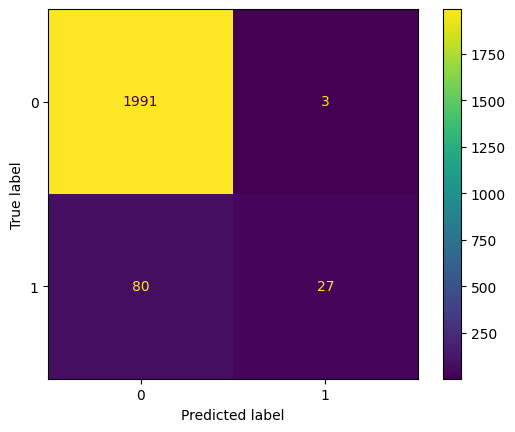

In [49]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_rf,X_test,y_test)
plt.show()

This matrix is a great reminder of how imbalanced our data is, and of why accuracy isn't always the best metric for judging whether or not a model is giving us what we want. 

The accuracy score will be amazing, but it won't tell us what we really need to know.

Instead, we can evaluate our model using two new metrics: precision and recall. 
 - The precision score is important when we want our model to only predict that a company will go bankrupt if its very confident in its prediction. 
 - The recall score is important if we want to make sure to identify all the companies that will go bankrupt, even if that means being incorrect sometimes.

In [52]:
# Print classification report
print(classification_report(y_test,model_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1994
           1       0.90      0.25      0.39       107

    accuracy                           0.96      2101
   macro avg       0.93      0.63      0.69      2101
weighted avg       0.96      0.96      0.95      2101



Because there's a tradeoff between precision (the quality of our prediction) and recall(the true quantity of true label), we should select between the measure of how "precise" our model and the measure of our model's ability base on reality. 

Hence depend on the aim, we could change the threshold to get the appropriate model. 

`Assumption:`

Let's say we work at a private equity firm that purchases distressed businesses, improve them, and then sells them for a profit. You want to build a model to predict which companies will go bankrupt so that you can purchase them ahead of your competitors. 

If the firm purchases a company that is indeed insolvent, it can make a profit of €100 million or more. But if it purchases a company that isn't insolvent and can't be resold at a profit, the firm will lose €250 million.

`Solution:`

For a model like this, we want to focus on ***precision***. If we're trying to maximize our profit, the quality of our predictions is much more important than the quantity of our predictions. 

It's not a big deal if we don't catch every single insolvent company, but it's **definitely** a big deal if the companies we catch don't end up becoming insolvent.

In [61]:
def make_cnf_matrix(threshold):
    
    # Define prediction 
    y_pred_proba = model_rf.predict_proba(X_test)[:,-1]
    y_pred = y_pred_proba > threshold
    conf_matrix = confusion_matrix(y_test,y_pred)
    
    # Calculate the values in confusion matrx 
    tn,fp,fn,tp = conf_matrix.ravel()

    print(f'Profit: ${round(tp * 0.1,2)} billion')
    print(f'Loss: ${round(fp * 0.25,2)} billion')
    print(f'Diff between Profit and Loss:  ${round((tp*0.1)-(fp*0.25),2)} billion')
    
    # Visual the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred, colorbar=False)
    plt.show()

In [62]:
thresh_widget = widgets.FloatSlider(value=0.5,
                                    min=0,
                                    max=1,
                                    step=0.05)

interact(make_cnf_matrix, threshold=thresh_widget);

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

# Communication

In [82]:
# Save model 
with open('clf-model.pkl',mode='wb') as f:
    pickle.dump(model_rf,f)

In [83]:
from predictor import make_predictions, wrangle
file = r'dataset/2year.arff'
model_name = 'clf-model.pkl'

In [84]:
# Generate predictions
y_test_pred = make_predictions(
    data_filepath= file,
    model_filepath= model_name,
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (10173,)


0    0
1    0
2    0
3    0
4    0
Name: bankrupt, dtype: int64